# Step 1: Project Setup and Environment

## 1.1 Install Necessary Libraries


Google Colab comes pre-installed with many libraries, but you will need to install a few others. Use the following cell to install the required packages:



In [36]:
# Install necessary libraries
!pip install google_play_scraper app_store_scraper tweepy pandas matplotlib seaborn nltk vaderSentiment textblob

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.1/41.1 kB 1.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of tweepy to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of tweepy to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.0/128.0 kB 10.2 MB/s eta 0:00:00
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:
      Successfully uninstalled chardet-5.2.0
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.2

## 1.2 Import Libraries


Once the installation is complete, import the necessary libraries to your Colab environment:



In [23]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from wordcloud import WordCloud


## 1.3 Download NLTK Data


Google Colab is a fresh environment, so you will need to download the stopwords for NLTK:



In [24]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Step 2: Data Collection


## 2.1 Collect Reviews from the Google Play Store
:

For scraping app reviews from Google Play Store, use the google-play-scraper:



In [25]:
!pip install google-play-scraper


In [37]:
from google_play_scraper import Sort, reviews
import pandas as pd

# Fetch reviews from Google Play Store for Netflix
google_reviews, _ = reviews(
    'com.netflix.mediaclient',  # Netflix package name on Google Play Store
    lang='en',
    country='us',
    sort=Sort.NEWEST,
    count=1000  # Number of reviews to scrape
)

# Convert reviews to a DataFrame
google_reviews_df = pd.DataFrame(google_reviews)
google_reviews_df = google_reviews_df[['content', 'score', 'at']]
google_reviews_df.columns = ['Review_Text', 'Rating', 'Date']

# Preview Google Play reviews
google_reviews_df.head()


,Review_Text,Rating,Date
0,I have infinix note 30 vip and the video keep ...,4,2024-10-19 21:26:14
1,Ewww disgusting,1,2024-10-19 21:24:24
2,The best app,5,2024-10-19 21:16:54
3,It so helpful for being cool 😍😍,5,2024-10-19 21:14:09
4,I leik natflik,5,2024-10-19 20:57:53


## 2.2 Collect Reviews from the Apple App Store

We will use the app_store_scraper to fetch Netflix reviews from the Apple App Store.



In [38]:
from app_store_scraper import AppStore

# Initialize the AppStore scraper for Netflix in the US
app_store_reviews = AppStore(country="us", app_name="netflix", app_id="363590051")

# Fetch reviews
app_store_reviews.review(how_many=1000)

# Convert to DataFrame
apple_reviews_df = pd.DataFrame(app_store_reviews.reviews)

# Select relevant columns
apple_reviews_df = apple_reviews_df[['review', 'rating', 'date']]
apple_reviews_df.columns = ['Review_Text', 'Rating', 'Date']

# Preview Apple App Store reviews
apple_reviews_df.head()


,Review_Text,Rating,Date
0,I’ve had Netflix since 2014 and I’ve never had...,4,2024-06-09 00:27:19
1,I have been using Netflix for years now. It is...,5,2022-10-25 17:26:12
2,Since last December I was watching Korean seri...,4,2024-07-15 00:36:58
3,I live in 2 different apartments during the we...,2,2024-02-10 00:29:52
4,Oh Netflix. I will say navigation is better on...,3,2023-04-12 01:52:51


## 2.3 Combine Reviews from All Sources

In [42]:
# Add a source column to each DataFrame
google_reviews_df['Source'] = 'Google Play Store'
apple_reviews_df['Source'] = 'Apple App Store'

# Combine the DataFrames
all_reviews_df = pd.concat([google_reviews_df, apple_reviews_df], ignore_index=True)

# Preview the combined DataFrame
all_reviews_df.head()


,Review_Text,Rating,Date,Source
0,I have infinix note 30 vip and the video keep ...,4,2024-10-19 21:26:14,Google Play Store
1,Ewww disgusting,1,2024-10-19 21:24:24,Google Play Store
2,The best app,5,2024-10-19 21:16:54,Google Play Store
3,It so helpful for being cool 😍😍,5,2024-10-19 21:14:09,Google Play Store
4,I leik natflik,5,2024-10-19 20:57:53,Google Play Store


# Step 3: Data Preprocessing


Before performing sentiment analysis, clean the text data to remove special characters, stopwords, and lowercase the text.



In [43]:
import re
import nltk
from nltk.corpus import stopwords

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Function to clean text
def clean_text(text):
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

# Apply the cleaning function
all_reviews_df['Cleaned_Review'] = all_reviews_df['Review_Text'].apply(clean_text)

# Preview cleaned reviews
all_reviews_df.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Review_Text,Rating,Date,Source,Cleaned_Review
0,I have infinix note 30 vip and the video keep ...,4,2024-10-19 21:26:14,Google Play Store,infinix note 30 vip video keep freezing dont f...
1,Ewww disgusting,1,2024-10-19 21:24:24,Google Play Store,ewww disgusting
2,The best app,5,2024-10-19 21:16:54,Google Play Store,best app
3,It so helpful for being cool 😍😍,5,2024-10-19 21:14:09,Google Play Store,helpful cool
4,I leik natflik,5,2024-10-19 20:57:53,Google Play Store,leik natflik


# Step 4: Sentiment Analysis


## 4.1 Sentiment Analysis with VADER


Now, apply the VADER sentiment analysis model to the cleaned reviews:



In [44]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to apply VADER sentiment analysis
def get_vader_sentiment(text):
    score = analyzer.polarity_scores(text)
    if score['compound'] >= 0.05:
        return 'Positive'
    elif score['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply VADER sentiment analysis
all_reviews_df['VADER_Sentiment'] = all_reviews_df['Cleaned_Review'].apply(get_vader_sentiment)

# Preview the sentiment analysis results
all_reviews_df[['Cleaned_Review', 'VADER_Sentiment']].head()


,Cleaned_Review,VADER_Sentiment
0,infinix note 30 vip video keep freezing dont f...,Positive
1,ewww disgusting,Negative
2,best app,Positive
3,helpful cool,Positive
4,leik natflik,Neutral


## 4.2 Sentiment Analysis with TextBlob

Alternatively, you can use TextBlob for sentiment analysis:



In [45]:
from textblob import TextBlob

# Function to apply TextBlob sentiment analysis
def get_textblob_sentiment(text):
    blob = TextBlob(text)
    if blob.sentiment.polarity > 0:
        return 'Positive'
    elif blob.sentiment.polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Apply TextBlob sentiment analysis
all_reviews_df['TextBlob_Sentiment'] = all_reviews_df['Cleaned_Review'].apply(get_textblob_sentiment)

# Preview the sentiment analysis results
all_reviews_df[['Cleaned_Review', 'TextBlob_Sentiment']].head()


,Cleaned_Review,TextBlob_Sentiment
0,infinix note 30 vip video keep freezing dont f...,Neutral
1,ewww disgusting,Negative
2,best app,Positive
3,helpful cool,Positive
4,leik natflik,Neutral


# Step 5: Data Visualization


## 5.1 Sentiment Distribution


5.1 Sentiment Distribution by Source


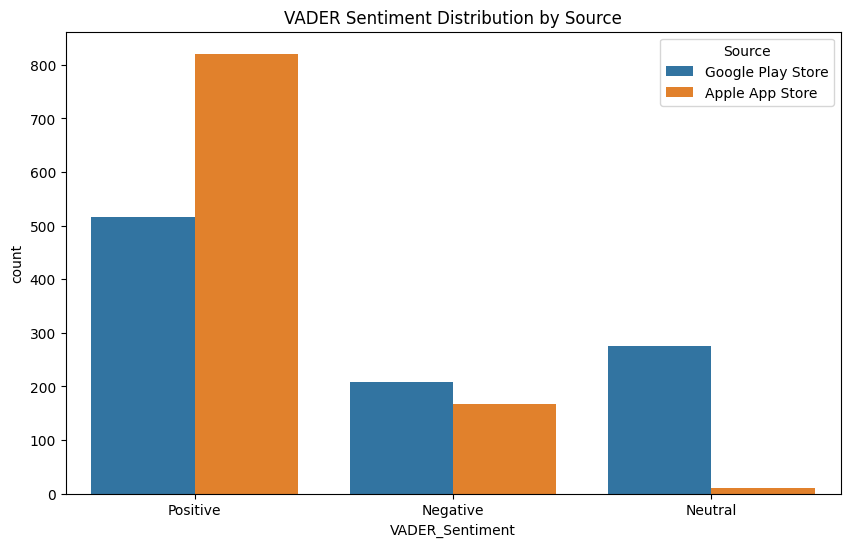

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot sentiment distribution by source using VADER
plt.figure(figsize=(10, 6))
sns.countplot(x='VADER_Sentiment', hue='Source', data=all_reviews_df)
plt.title('VADER Sentiment Distribution by Source')
plt.show()


In VADER Sentiment, the Google Play Store has a notable portion of neutral and negative reviews, whereas the Apple App Store is skewed more toward positivity.


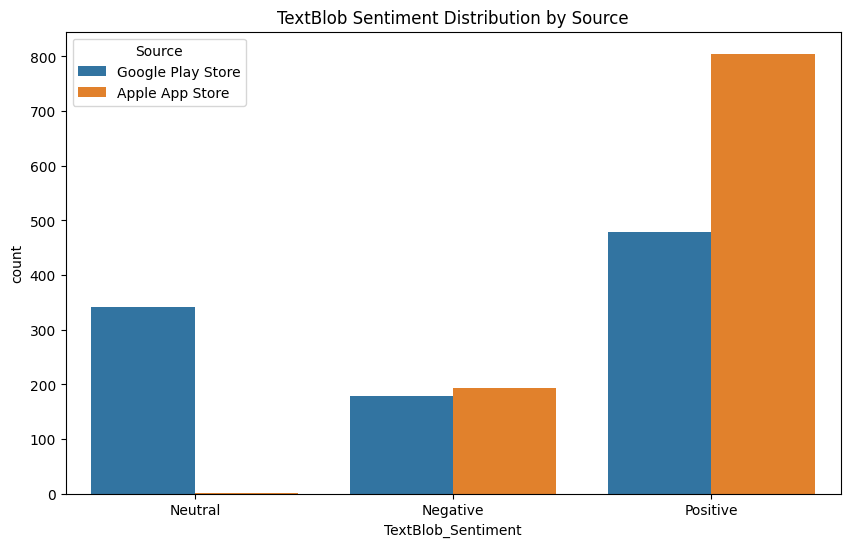

In [49]:

# Plot sentiment distribution by source using TextBlob
plt.figure(figsize=(10, 6))
sns.countplot(x='TextBlob_Sentiment', hue='Source', data=all_reviews_df)
plt.title('TextBlob Sentiment Distribution by Source')
plt.show()


In TextBlob Sentiment, we see a similar pattern: Apple App Store reviews are overwhelmingly positive, while Google Play reviews are more mixed.


## 5.2 Word Cloud for Positive and Negative Reviews






Generate word clouds to visualize the most frequent words in positive and negative reviews:



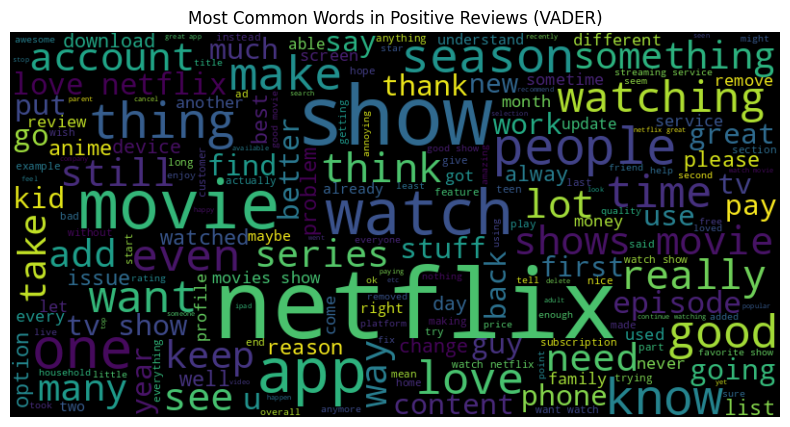

In [47]:
from wordcloud import WordCloud

# Generate word clouds for positive and negative reviews using VADER
positive_reviews = ' '.join(all_reviews_df[all_reviews_df['VADER_Sentiment'] == 'Positive']['Cleaned_Review'])
negative_reviews = ' '.join(all_reviews_df[all_reviews_df['VADER_Sentiment'] == 'Negative']['Cleaned_Review'])

# Word cloud for positive reviews
wordcloud_positive = WordCloud(width=800, height=400, max_font_size=100).generate(positive_reviews)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Positive Reviews (VADER)')
plt.show()


**Key Themes**: The most prominent words in positive reviews include "Netflix," "watch," "movie," "app," "show," "series," "love," "good," "seasons," and "episodes."

**User Satisfaction**: Users are very satisfied with Netflix’s core offering of movies, TV shows, and series. The frequent appearance of words like "love," "good," "great," "watch," and "enjoy" reflects positive engagement with Netflix’s content.

**Actionable Insight**: Netflix should continue to focus on content quality and diversity, particularly in popular genres like movies, TV series, and anime. Adding more content in these categories will likely keep the positive sentiment high.

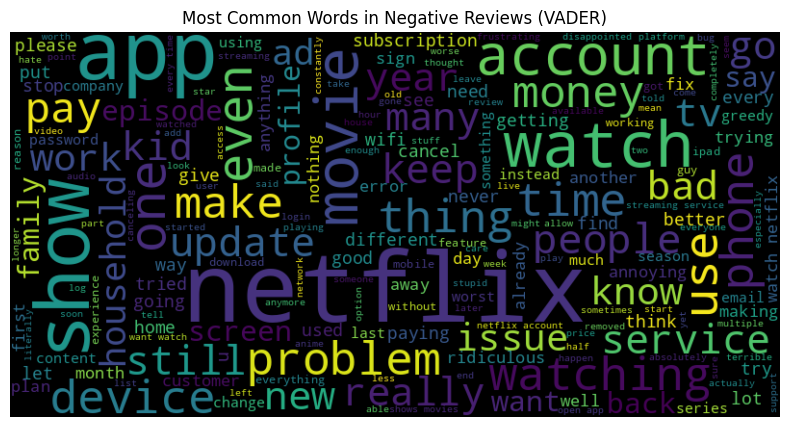

In [48]:

# Word cloud for negative reviews
wordcloud_negative = WordCloud(width=800, height=400, max_font_size=100).generate(negative_reviews)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Negative Reviews (VADER)')
plt.show()


**Key Themes**: In the negative reviews, the dominant words include "account," "service," "problem," "issue," "money," "pay," "device," and "watch."

**User Dissatisfaction**: Many negative reviews are related to technical issues (e.g., app functionality, account access) and financial concerns (e.g., payment issues, subscription costs). Problems with the app on different devices and issues with customer service seem to be major pain points.

**Actionable Insight**: Netflix should focus on resolving technical issues, especially related to app performance on different devices. Improving customer service, particularly regarding account management and billing, could also significantly reduce negative feedback.

# Conclusion and Recommendations:


**Optimize Android Experience**: The higher proportion of negative and neutral reviews from Google Play Store users indicates potential performance issues on Android devices. Netflix should prioritize technical fixes and improvements for Android users to bring their satisfaction in line with iOS users.

**Improve Customer Support for Account/Billing**: Given the frequent mentions of "account," "pay," and "money" in negative reviews, Netflix should enhance its customer service, especially in areas related to account management and billing.

**Continue Investing in Content**: Positive reviews overwhelmingly highlight satisfaction with Netflix’s content, including shows, movies, and series. Netflix should continue to invest in high-quality, diverse content offerings to maintain high user engagement and satisfaction.